In [198]:
import pip
# pip.main(['install', '{insert_pckg_here}'])
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Training/Testing Data:

In [199]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

train_df = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
test_df = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Preprocessing:

In [200]:
# create df that consists of columns and the number of missing values for each 
data = train_df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

# add column and fill it with the percentage of those missing values
missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/train_df.shape[0] * 100)) 
missing_df = missing_df[missing_df.missing_cnt > 0]
missing_df

,missing_cnt,percent_missing
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageCond,81,5.55
GarageFinish,81,5.55
GarageQual,81,5.55


In [201]:
# drop the columns where majority of their values are missing
train_df = train_df.drop(['PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu'], axis = 1)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [202]:
train_df1 = pd.get_dummies(data=train_df , columns=['MSZoning','Street', 'Alley', 'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                                                   'BldgType', 'HouseStyle'])
train_df1.head()

,MSSubClass,LotFrontage,LotArea,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,...,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,Norm,Norm,7,5,2003,2003,Gable,...,0,0,0,0,0,0,0,1,0,0
2,20,80.0,9600,Feedr,Norm,6,8,1976,1976,Gable,...,0,0,0,0,1,0,0,0,0,0
3,60,68.0,11250,Norm,Norm,7,5,2001,2002,Gable,...,0,0,0,0,0,0,0,1,0,0
4,70,60.0,9550,Norm,Norm,7,5,1915,1970,Gable,...,0,0,0,0,0,0,0,1,0,0
5,60,84.0,14260,Norm,Norm,8,5,2000,2000,Gable,...,0,0,0,0,0,0,0,1,0,0


In [203]:
# creating a generic dictionary to hold numercial values to represent categorical values
# for quality related columns (ExterQual, BsmtQual)
quality_ratings = {
 'NA':0,
 'Po':1, 
 'Fa':2, 
 'TA':3, 
 'Gd':4, 
 'Ex':5
}

In [204]:
# Converting category labels to numerical values for ExterQual column
train_df['ExterQual_Num'] = train_df.ExterQual.map(quality_ratings)

In [205]:
# Converting category labels to numerical values for BsmtQual column
train_df['BsmtQual_Num'] = train_df.BsmtQual.map(quality_ratings)

In [206]:
# Converting category labels to numerical values for HeatingQC column
train_df['HeatingQC_Num'] = train_df.HeatingQC.map(quality_ratings)

In [207]:
# Converting category labels to numerical values for KitchenQual column
train_df['KitchenQual_Num'] = train_df.KitchenQual.map(quality_ratings)

In [208]:
# Converting category labels to numerical values for GarageQual column
train_df['GarageQual_Num'] = train_df.GarageQual.map(quality_ratings)

In [209]:
# Converting category labels to numerical values for SaleCondition column
train_df['SaleCondition_Num'] = train_df.SaleCondition.map(
{'Abnorml':1, 
 'AdjLand':2, 
 'Alloca':3, 
 'Family':4, 
 'Normal':5,
 'Partial':6})

In [210]:
# NA is a valid value and is some cases not equivalent to NaN and should not be converted to 0
# replace null values in df w/ values that had most counts for each column
train_df1 = train_df1.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
                          else x.fillna(train_df.columns.value_counts().idxmax()))
test_df = test_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
                          else x.fillna(train_df.columns.value_counts().idxmax()))

In [211]:
# encode object (categorical) columns in df
enc_df = train_df1.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

# add encoded columns back into original train df
train_df1[enc_df.columns] = enc_df

train_df1.head()

,MSSubClass,LotFrontage,LotArea,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,...,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,2,2,7,5,2003,2003,1,...,0,0,0,0,0,0,0,1,0,0
2,20,80.0,9600,1,2,6,8,1976,1976,1,...,0,0,0,0,1,0,0,0,0,0
3,60,68.0,11250,2,2,7,5,2001,2002,1,...,0,0,0,0,0,0,0,1,0,0
4,70,60.0,9550,2,2,7,5,1915,1970,1,...,0,0,0,0,0,0,0,1,0,0
5,60,84.0,14260,2,2,8,5,2000,2000,1,...,0,0,0,0,0,0,0,1,0,0


## Data Exploration:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122ed8a90>]],
      dtype=object)

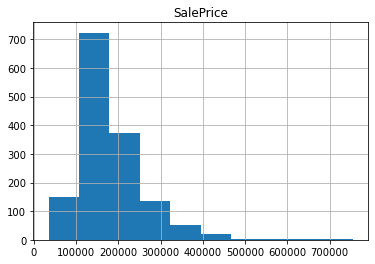

In [212]:
# check distribution of sales price
train_df1.hist(column='SalePrice')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122d21880>]],
      dtype=object)

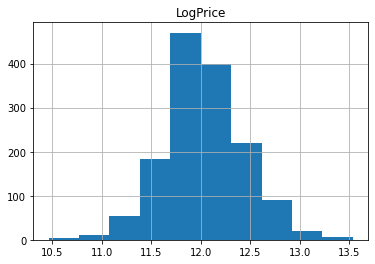

In [213]:
# normalize sale price so that it can be evenly distributed
train_df1['LogPrice'] = np.log(train_df1.SalePrice)
train_df1.hist(column='LogPrice')

In [214]:
# check for more skewed columns
train_df1.skew().sort_values(ascending=False).head(30)

Utilities_NoSeWa        38.209946
Neighborhood_Blueste    26.990701
MiscVal                 24.476794
LotConfig_FR3           19.045943
Street_Grvl             15.518770
PoolArea                14.828374
HouseStyle_2.5Fin       13.411750
Condition2              13.171844
Neighborhood_NPkVill    12.631556
LotArea                 12.207688
MSZoning_C (all)        11.970851
LotShape_IR3            11.970851
HouseStyle_2.5Unf       11.401839
Neighborhood_Veenker    11.401839
LandSlope_Sev           10.466218
3SsnPorch               10.304342
HouseStyle_1.5Unf       10.074915
Heating                  9.855100
Neighborhood_BrDale      9.404402
MSZoning_RH              9.404402
Neighborhood_MeadowV     9.113988
Neighborhood_Blmngtn     9.113988
LowQualFinSF             9.011341
RoofMatl                 8.109402
Neighborhood_StoneBr     7.451946
Neighborhood_SWISU       7.451946
Neighborhood_ClearCr     7.018804
BldgType_2fmCon          6.649007
LandContour_Low          6.136628
HouseStyle_SFo

In [409]:
# looking at correlation of numeric features to SalePrice column. 
# this will suggest which columns have a greater relationship with the SalePrice column 
corr = train_df1.corr().abs().unstack().sort_values(ascending=False)['LogPrice']
corr = corr.iloc[1:]
corr = pd.DataFrame(corr, columns = ['Correlation'])

corr = corr[corr.Correlation > 0.50]
corr

OverallQual             0.790982
GrLivArea               0.708624
ExterQual_Num           0.682639
KitchenQual_Num         0.659600
GarageCars              0.640409
ExterQual               0.636884
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
BsmtQual                0.593734
KitchenQual             0.589189
BsmtQual_Num            0.585207
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
FireplaceQu_Num         0.520438
YearRemodAdd            0.507101
MasVnrArea              0.472614
Fireplaces              0.466929
HeatingQC_Num           0.427649
GarageFinish            0.425684
GarageType              0.415283
Neighborhood_NridgHt    0.402149
HeatingQC               0.400178
BsmtFinSF1              0.386420
Foundation              0.382479
Neighborhood_NoRidge    0.330424
WoodDeckSF              0.324413
2ndFlrSF                0.319334
OpenPorchSF             0.315856
MSZoning_R

Text(0.5, 1.0, 'Price vs Overall Quality')

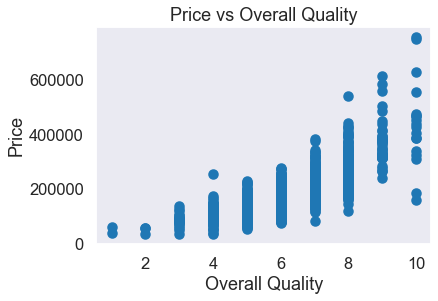

In [410]:
cols = []
for ind in corr.index:
    cols.append(ind)

# create pair plot between columns that have correlation 50% and above
sns.pairplot(train_df1[cols])

## Data Visualization (CAN BE DELETED):

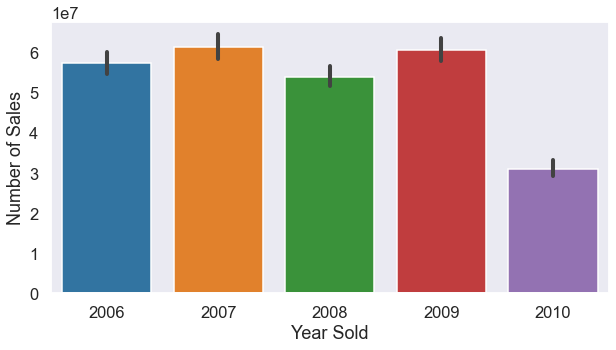

In [413]:
#Count the number of houses sold in a year
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc='count')
#print(year_sold_pivot)

# Plotting the sum of sales per year
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=sum)
plt.xlabel('Year Sold')
plt.ylabel('Number of Sales')
plt.show()

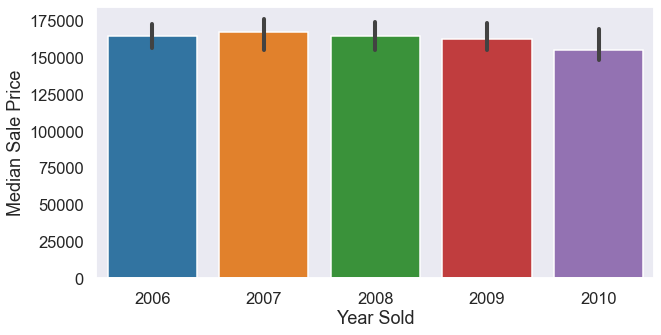

In [414]:
# Plotting the median sale price for each year

#Checking the median price
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc=np.median)
#print(year_sold_pivot)

sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=np.median)
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

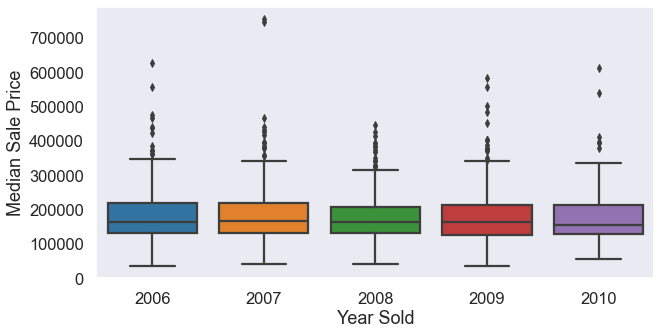

In [415]:
#Displaying the median price for each year using box plot.  
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.boxplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']])
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

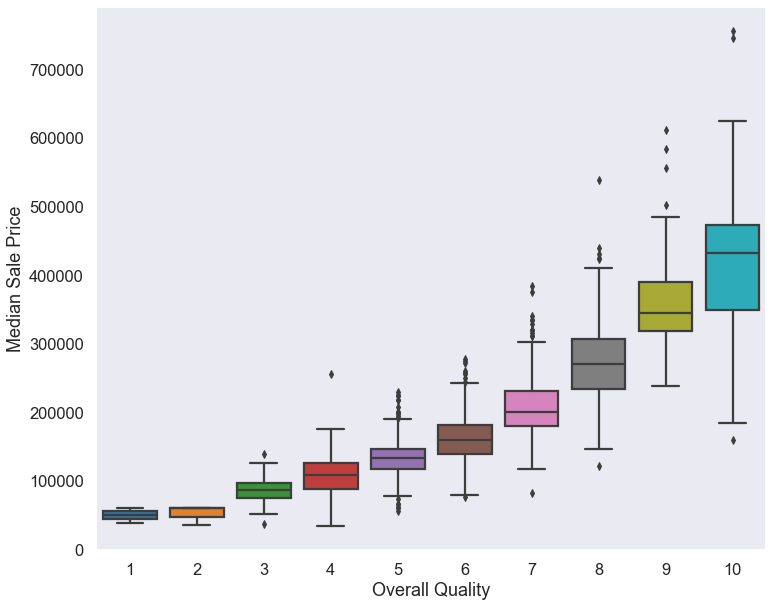

In [416]:
# Displaying the median price based on overall quality of the house using box plot.
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(12,10))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df[['SalePrice', 'OverallQual']])
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

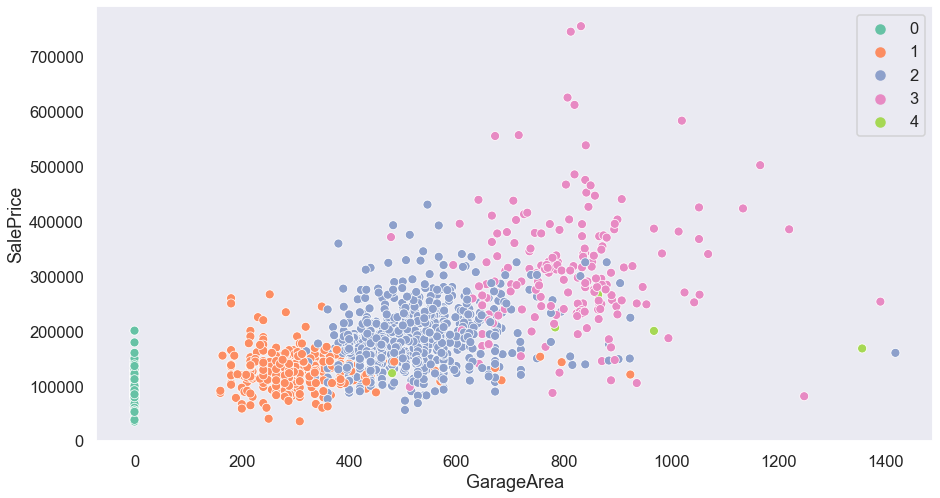

In [417]:
sns.set_context('talk', font_scale=1) 
sns.set_style('dark')
plt.figure(figsize=(15,8))

# Plot GarageArea vs sale price of house considering the number of cars that can
# fit in the garage
sns.scatterplot(x='GarageArea', y='SalePrice', hue=train_df.GarageCars.tolist(),
            palette='Set2', data=train_df[['SalePrice', 'GarageArea','GarageCars']])
plt.show()

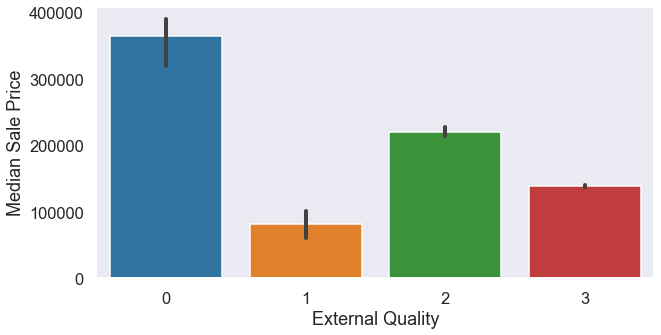

In [418]:
# Plotting the median sale price based on external quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='ExterQual', y='SalePrice', data=train_df[['SalePrice', 'ExterQual']], estimator=np.median)
plt.xlabel('External Quality')
plt.ylabel('Median Sale Price')
plt.show()

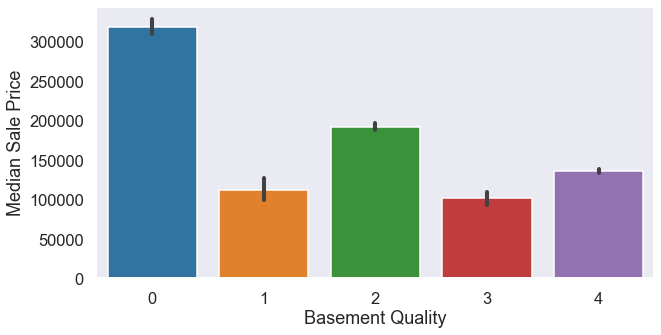

In [419]:
# Plotting the median sale price based on basement quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='BsmtQual', y='SalePrice', data=train_df[['SalePrice', 'BsmtQual']], estimator=np.median)
plt.xlabel('Basement Quality')
plt.ylabel('Median Sale Price')
plt.show()

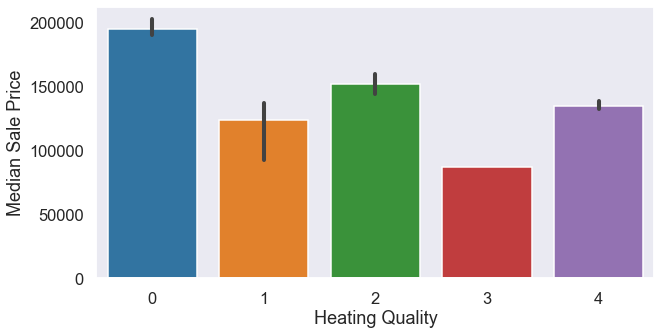

In [420]:
# Plotting the median sale price based on heating and air conditioning quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='HeatingQC', y='SalePrice', data=train_df[['SalePrice', 'HeatingQC']], estimator=np.median)
plt.xlabel('Heating Quality')
plt.ylabel('Median Sale Price')
plt.show()

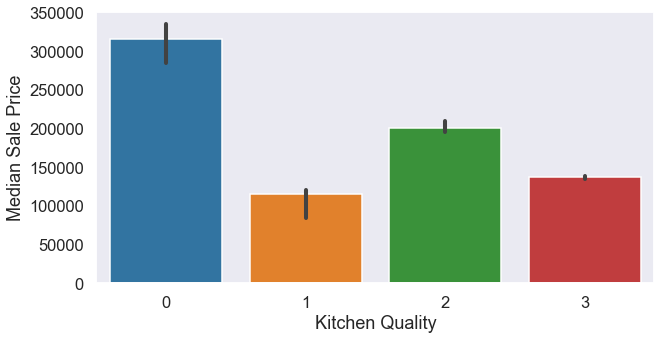

In [421]:
# Plotting the median sale price based on kitchen quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='KitchenQual', y='SalePrice', data=train_df[['SalePrice', 'KitchenQual']], estimator=np.median)
plt.xlabel('Kitchen Quality')
plt.ylabel('Median Sale Price')
plt.show()

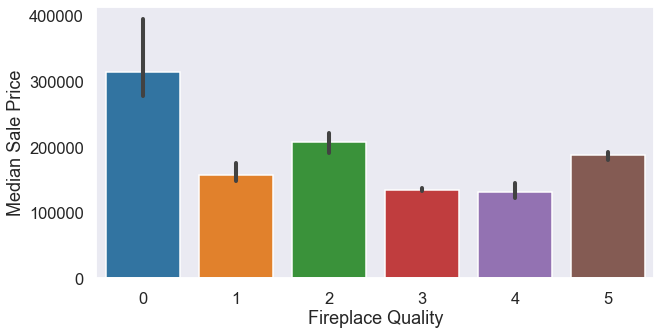

In [422]:
# Plotting the median sale price based on fireplace quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='FireplaceQu', y='SalePrice', data=train_df[['SalePrice', 'FireplaceQu']], estimator=np.median)
plt.xlabel('Fireplace Quality')
plt.ylabel('Median Sale Price')
plt.show()

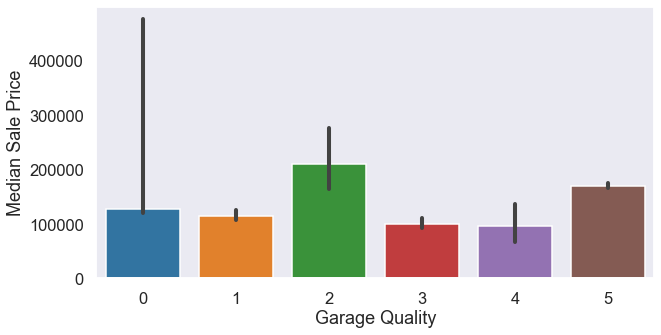

In [423]:
# Plotting the median sale price based on garage quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='GarageQual', y='SalePrice', data=train_df[['SalePrice', 'GarageQual']], estimator=np.median)
plt.xlabel('Garage Quality')
plt.ylabel('Median Sale Price')
plt.show()

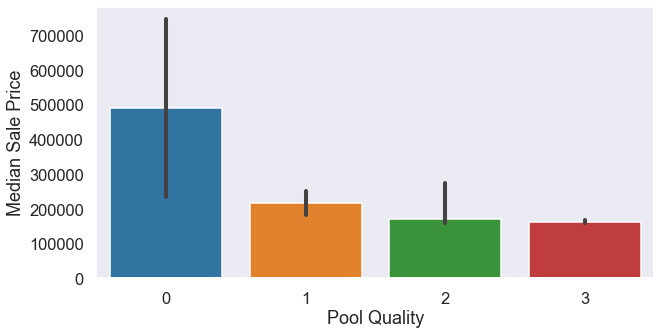

In [424]:
# Plotting the median sale price based on pool quality
sns.set_context('talk', font_scale=1) 
plt.figure(figsize=(10,5))
sns.barplot(x='PoolQC', y='SalePrice', data=train_df[['SalePrice', 'PoolQC']], estimator=np.median)
plt.xlabel('Pool Quality')
plt.ylabel('Median Sale Price')
plt.show()

## Feature Engineering:

In [425]:
# sum of quality points.
train_df['SumQuality'] = train_df.ExterQual_Num + train_df.BsmtQual_Num + train_df.HeatingQC_Num + train_df.KitchenQual_Num + train_df.GarageQual_Num + train_df.FireplaceQu_Num + train_df.GarageQual_Num + train_df.PoolQC_Num 
            
#print(train_df['SumQuality'])

# sum of quality points, removing less correlated features (< 0.5).
train_df['SumMIQ'] = train_df.ExterQual_Num + train_df.BsmtQual_Num + train_df.KitchenQual_Num + train_df.FireplaceQu_Num + train_df.GarageQual_Num


In [426]:
# Garage area per car
# May not need this one, the correlation to SalePrice is only slightly higher than GarageArea
train_df['GarageAreaPerCar'] = train_df.GarageArea + train_df.GarageCars 

#print(train_df['GarageAreaPerCar'])

In [427]:
corr = train_df.corr().abs().unstack().sort_values(ascending=False)['SalePrice']
corr.head(40)

SalePrice               1.000000
OverallQual             0.790982
SumMIQ                  0.753830
SumQuality              0.740640
GrLivArea               0.708624
ExterQual_Num           0.682639
KitchenQual_Num         0.659600
GarageCars              0.640409
ExterQual               0.636884
GarageAreaPerCar        0.623745
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
BsmtQual                0.593734
KitchenQual             0.589189
BsmtQual_Num            0.585207
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
FireplaceQu_Num         0.520438
YearRemodAdd            0.507101
MasVnrArea              0.472614
Fireplaces              0.466929
HeatingQC_Num           0.427649
GarageFinish            0.425684
GarageType              0.415283
Neighborhood_NridgHt    0.402149
HeatingQC               0.400178
BsmtFinSF1              0.386420
Foundation              0.382479
Neighborho

In [428]:
################## DISREGARD LOGIC BELOW ######################

In [429]:
# encode object columns
# enc_df = train_df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)
# enc_df

In [430]:
# add encoded columns back into train df
# train_df[enc_df.columns] = enc_df
# train_df

In [431]:
# normalize df except for price column
# norm_df = (train_df - train_df.mean()) / (train_df.max() - train_df.min())